In [1]:
from board3 import Board3, sqr_distance, empty_cells, tod_cells
from controller3 import ActionController, MW_CELLS
import time
from heapq import heappush, heappop
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical
from collections import Counter
from mcts import search
from nnl import gather_history

In [2]:
def to_emb(board: Board3):

    py, px = board.get_player_position()
    ey, ex = board.get_enemy_position()
    ty, tx = board.get_todd_position()

    pe = nn.functional.one_hot(torch.LongTensor([py, px, ey, ex, ty, tx]), 4).reshape(1, -1)

    mws = [0] * 16

    for (y, x) in board.mw:
        mws[y * 4 + x] = 1

    mwe = torch.Tensor([mws])

    return torch.cat([pe, mwe], dim=1)


def emb_mem(mem, nc=2):
    fe = []
    for b, a in mem:
        e1 = to_emb(b)
        e2 = nn.functional.one_hot(torch.LongTensor([a]), num_classes=nc)
        fe.append(torch.cat([e1, e2], dim=1))

    return torch.cat(fe, dim=0).unsqueeze(0)

In [3]:
class FP(nn.Module):
    def __init__(self, n_dim, a_space):
        super(FP, self).__init__()
        self.n_dim = n_dim
        self.a_space = a_space
        self.fc = nn.Sequential(
            nn.Linear(n_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256)
        )

        # self.hf = nn.Sequential(
        #     nn.Flatten(start_dim=1),
        #     nn.BatchNorm1d(120),
        #     nn.Linear(120, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(128, 256),
        # )


        self.fp = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, a_space),
            nn.Softmax(dim=-1)
        )

        self.fv = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 1),
        )

    def forward(self, x):
        hidden = self.fc(x)
        return self.fp(hidden), self.fv(hidden)




In [6]:
def play(fp, board_builder, runs=100, step=1600, best_action=False):
    fp.eval()

    b = board_builder()

    controller = ActionController(b)
    h = []

    for _ in range(runs):

        with torch.no_grad():
            o, _ = fp(to_emb(b))
            if not best_action:
                c = Categorical(o)
                a = c.sample()
                h.append((b.copy(), c.log_prob(a), a))

            else:
                a = o.argmax().item()

        controller.execute_action(a)
        b.step(step)

        if controller.is_win():
            return h, 1
        if controller.is_block():
            return h, -1
        if controller.is_lose():
            return h, -1

    return h, 0


def gen_data(board_builder, n=100, runs=100, step=1600):

    boards = []
    logs = []
    actions = []
    rewards = []

    while len(boards) < n:

        h, r = play(fp, board_builder=board_builder, runs=runs, step=step)

        b, l, a = list(zip(*h))

        boards.extend([to_emb(x) for x in b])
        logs.extend(l)
        actions.extend(a)
        rewards.extend(reversed([r * 0.85 ** n for n in range(len(b))]))

    revs = torch.Tensor(rewards)
    revs = (revs - revs.mean()) / (revs.std() + 1e-6)
    return TensorDataset(torch.cat(boards, dim=0), torch.Tensor(logs), torch.LongTensor(actions), revs)


def test_fp(fp, board_builder, n=40, runs=100, step=1600):
    wins = 0
    lose = 0

    for _ in range(n):
        h, r = play(fp, board_builder=board_builder, runs=runs, step=step, best_action=True)
        if r == 1:
            wins += 1
        else:
            lose += 1

    return wins / n, lose / n


def train_nn(fp, data, epochs=5, lr=0.001, batch=32):
    optimizer = optim.SGD(fp.parameters(), lr=lr)

    fp.train()
    lh = []
    for _ in range(epochs):
        el = []
        for b, l, a, r in DataLoader(data, batch_size=batch, shuffle=True):
            optimizer.zero_grad()
            y, v = fp(b)
            ct = Categorical(y)
            loss = torch.sum(ct.log_prob(a) * (r - v.detach())) + (v - r).pow(2).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(fp.parameters(), 1)
            optimizer.step()
            el.append(loss.item())

        lh.append(sum(el) / len(el))

    return lh

  0%|          | 0/200 [00:00<?, ?it/s]

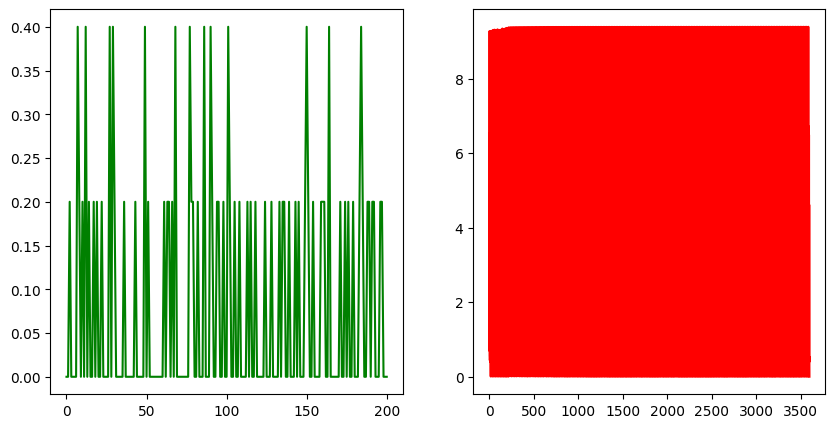

In [7]:

def board_lvl_0():
    b = Board3(walk_time=1000)
    # b.players_positions = [(3, 0), (0, 2), (3, 3)]
    # b.set_enemy(*random.choice([(0, 0)]))
    return b


fp = FP(to_emb(Board3()).shape[1], ActionController.get_action_space())




test_n = 5
game_runs = 100
data_n = 1024 * 30
step = 1600

epochs = 4
lr = 0.001
batch = 64

wh = []
lh = []
weight_h = []

builders = [
    board_lvl_0
]

lvl = 0

# data = gen_data(builders[lvl], n=data_n, runs=game_runs, step=step)
for _ in tqdm(range(200)):

    w, l = test_fp(fp, builders[lvl], n=test_n, runs=game_runs, step=step )
    if w > 0.8 and lvl < len(builders) - 1:
        print('lvl increase')
        lvl += 1
    wh.append(w)
    lh.append(l)
    data = gen_data(builders[lvl], n=data_n, runs=game_runs, step=step)
    loss_h = train_nn(fp, data, epochs=epochs, lr=lr, batch=batch)

    for p in fp.parameters():
        weight_h.append(p.data.norm(2).item())

w, l = test_fp(fp, builders[lvl], n=test_n, runs=game_runs, step=step )
wh.append(w)
lh.append(l)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(wh, c='g')
ax[1].plot(weight_h, c='r')
plt.show()





  0%|          | 0/123052 [00:00<?, ?it/s]

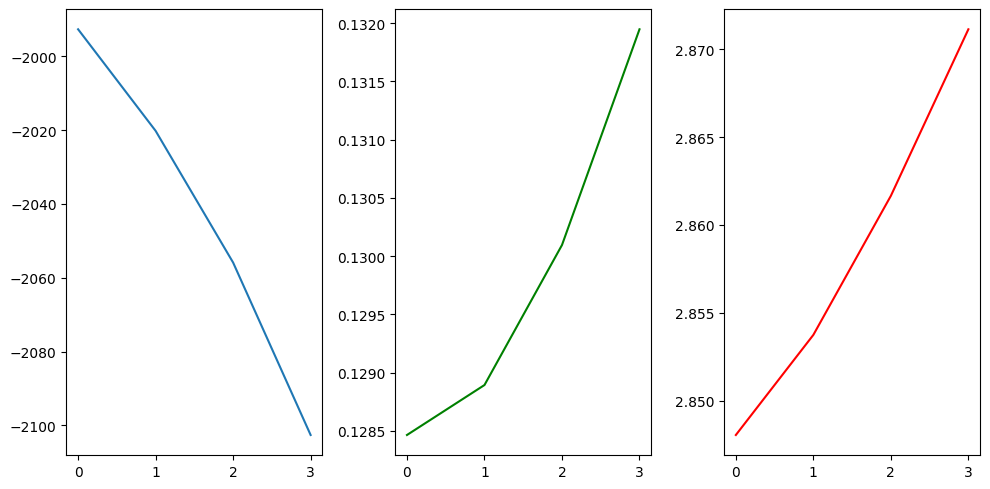

In [106]:
fp = FP(to_emb(Board3()).shape[1], ActionController.get_action_space())


optimizer = optim.SGD(fp.parameters(), lr=0.001)

progress = tqdm(total=len(data) * epochs)
fp.train()
lh = []
gs = []
wh = []
for _ in range(epochs):
    el = []
    gl = []
    ws = []
    for b, l, a, r in DataLoader(data, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y, v = fp(b)
        ct = Categorical(y)
        loss = torch.sum(ct.log_prob(a) * (r - v.detach())) + (v - r).pow(2).mean()
        loss.backward()

        nn.utils.clip_grad_norm_(fp.parameters(), 1)

        for p in fp.parameters():
            if p.grad is not None:
                gl.append(p.grad.data.norm(2).item())
            ws.append(p.data.norm(2).item())

        optimizer.step()
        el.append(loss.item())
        progress.update(b.shape[0])



    lh.append(sum(el) / len(el))
    gs.append(sum(gl) / len(gl))
    wh.append(sum(ws) / len(ws))

progress.close()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].plot(lh)
ax[1].plot(gs, c='g')
ax[2].plot(wh, c='r')
fig.tight_layout()

plt.show()

.  %  .  %
E  %  .  %
P  .  .  .
.  .  .  T
-0.13016024231910706


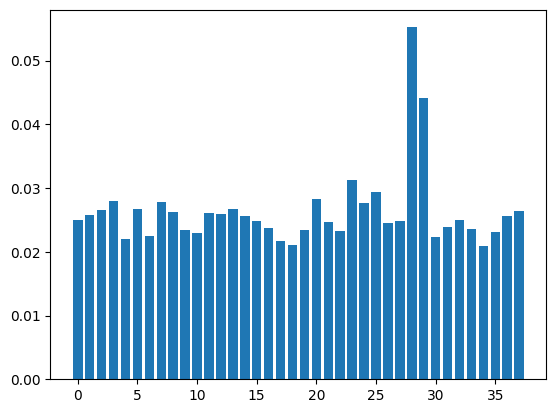

MW 1 0


In [108]:
board = Board3(walk_time=1000)
board.players_positions = [(2, 0), (1, 0), (3, 3)]

fp.eval()
print(board)
with torch.no_grad():
    o, v = fp(to_emb(board))
    print(v.item())
    plt.bar(range(o.shape[1]), o.squeeze(0))
    plt.show()
    print(ActionController.explain_action(o.exp().argmax().item()))